# CNN + Transfer learning 練習

## Transfer Learning 概念說明

<div align=left><img src="./slide_image/tf_slide0.png" width=800  /> 
<div align=left><img src="./slide_image/tf_slide1.png" width=800  /> 
<div align=left><img src="./slide_image/tf_slide2.png" width=800  /> 
<div align=left><img src="./slide_image/tf_slide3.png" width=800  /> 

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten)
import tensorflow as tf

## Where AM I 資料讀入及前處理

In [3]:
# data_path = "/datasets/aia-data2020/where_am_i/train"

# x_data_list = []
# y_data_list = []
# for roots, dirs, files in os.walk(data_path):
#     for each in files:
#         if each.find('checkpoint') == -1:
#             x_data_list.append(os.path.join(roots.split("/")[-1], each))
#             y_data_list.append(roots.split("/")[-1])

In [4]:
# data_list = pd.DataFrame({})
# data_list['img_path'] = x_data_list
# data_list['label'] = y_data_list

In [5]:
# data_list.head(3)

In [6]:
# from sklearn.model_selection import train_test_split

# train_list, test_list = train_test_split(data_list,
#                                          test_size=0.1,
#                                          random_state=42,
#                                          stratify=data_list['label'].values)

In [7]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [8]:

img_size = 32
num_class = len(np.unique(y_train))
print(img_size, num_class)

32 10


## 讀入 Pre-trained Model

<div align=left><img src="./slide_image/tf_slide4.JPG" width=700  /><br>
    
Reference: https://keras.io/applications/

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [10]:
vgg_model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(img_size, img_size, 3))

x = Flatten()(vgg_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=vgg_model.inputs, outputs=outputs)

# 決定 Pre-Train 參數量

* ### Pre-train model 用法有三
 1. 依照資料集相似度，固定住一些和你資料集相近的線段和圖案的權重 $\implies$ 固定權重 layer.trainable = False
 2. 可以把這些著名模型的權重當作起始值，全部再訓練過一次 $\implies$ learning rate 較大
 3. 針對你的資料集學習一點，更符合你資料集影像有的形狀即可，只對模型微調 Fine-tune  $\implies$ learning rate 較小

In [11]:
vgg_model.trainable = False

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [13]:
vgg_model.trainable = True

trainable_layer = 3
for layer in vgg_model.layers[:-trainable_layer]:
    layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

# model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f87349446d8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87d7ea4d30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87d8259320> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f872ae8ff60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872ae8ff28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872808c780> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f872809ba20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872809bda0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f872802a240> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f87280534e0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f8728061780> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [14]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

In [15]:
batch_size = 32
# num_steps = len(train_list) // batch_size + 1
num_steps = 1
num_epochs = 10

In [16]:
num_steps

1

In [17]:
# train_datagen = ImageDataGenerator(
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.1,
#                                    horizontal_flip=True,
#                                    preprocessing_function=preprocess_input
#                                   )
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
# X_train.shape

In [19]:
model_dir = 'model-logs/vgg16'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [20]:
img_shape = (img_size, img_size)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / 32,
                    epochs=num_epochs,
                   callbacks=callbacks_list)

Train for 1562.5 steps
Epoch 1/10
1563/1562 [==============================] - 46s 30ms/step - loss: 6893422.7039 - accuracy: 0.0286
Epoch 2/10
1563/1562 [==============================] - 43s 28ms/step - loss: 43072840.2740 - accuracy: 0.0329
Epoch 3/10
1563/1562 [==============================] - 43s 28ms/step - loss: 100097322.3806 - accuracy: 0.0357
Epoch 4/10
1563/1562 [==============================] - 43s 28ms/step - loss: 171473717.3042 - accuracy: 0.0406
Epoch 5/10
1563/1562 [==============================] - 43s 28ms/step - loss: 254147785.0712 - accuracy: 0.0439
Epoch 6/10
1563/1562 [==============================] - 43s 28ms/step - loss: 349140195.8290 - accuracy: 0.0458
Epoch 7/10
   1/1562 [..............................] - ETA: 11:55:09

KeyboardInterrupt: 

In [57]:
img_shape = (img_size, img_size)

# train_generator = train_datagen.flow(
#                                     dataframe=X_train,
#                                     directory=None,
#                                     x_col="img_path",
#                                     y_col="label",
#                                     target_size=img_shape,
#                                     batch_size=batch_size,
#                                     class_mode='categorical')
train_generator = train_datagen.flow(
                    X_train,
                    y=None,
                    batch_size=batch_size,
                    shuffle=True,
                    sample_weight=None,
                    seed=None,
                    save_to_dir=None,
                    save_prefix="",
                    save_format="png",
                    subset=None)

valid_generator = test_datagen.flow(
                    X_test,
                    y=None,
                    batch_size=batch_size,
                    shuffle=True,
                    sample_weight=None,
                    seed=None,
                    save_to_dir=None,
                    save_prefix="",
                    save_format="png",
                    subset=None)

# 用在不知道 label 的資料讀取上
# test_generator = test_datagen.flow_from_dataframe(
#                                                     dataframe=test_list,
#                                                     directory=data_path,
#                                                     x_col="img_path",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode=None,
#                                                     shuffle=False)


## 開始訓練模型

In [58]:
model_dir = 'model-logs/vgg16'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [59]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/10


IndexError: list index out of range

## 訓練結果視覺化

In [20]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

10/10 - 2s - loss: 0.3657 - accuracy: 0.9097


In [21]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [22]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9096989966555183
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  1  1  0  4]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  2  1  1]
 [ 0  0  0  0  0  0  0  1  9  0  0  0  1  0  0]
 [ 0  0  2  0  0  0  0  0  0 16  0  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 26  0  0  0  0]
 [ 0  0  0  2  1  0  0  0  0  0  1 27  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 26]]


Text(0.5, 1, 'Confusion Matrix')

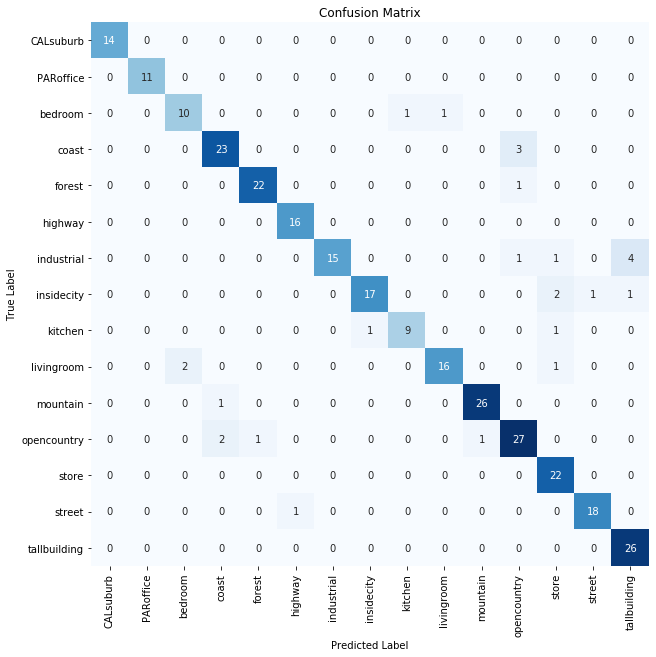

In [24]:
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

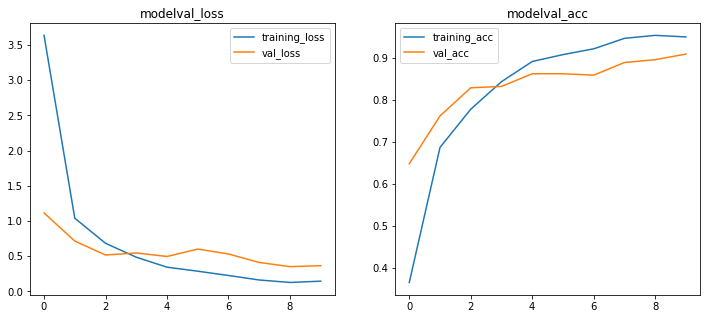

In [25]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()

### Transfer Learning 小總結

1. 每次都從無到有搭建、訓練模型，太耗時耗神了！
2. 訓練資料少也可以有一些的訓練成果
3. 藉由借用別人經驗，大大提升模型的表現